# Analysis of the Human and Elephant P53 Genes

## Jonathan Taylor

In this project, I use data analysis to process and analyze DNA sequences for the gene p53, which is used to suppress cancer in organisms. Specifically, I compare the p53 genes in humans and elephants, to identify what they have in common and how they are different.

To do this, I interpret DNA data files from the NIH, convert them to RNA, then convert that to a sequence of generated proteins. Next, I compare the protein sequences of the two different genes, automatically generate text reports of your findings, and graph the results, which are displayed at the bottom of this notebook.

The data that is used for this project is retrieved from the NIH Gene Database.

* Human p53 Gene:
    - https://www.ncbi.nlm.nih.gov/nuccore/NC_000017.11?report=fasta&from=7668402&to=7687550&strand=true
    
* Elephant p53 Gene:
    - https://www.ncbi.nlm.nih.gov/nuccore/NW_003573467.1?report=fasta&from=11687413&to=11699835&strand=true
    

DNA is composed of four bases: cytosine (C), guanine (G), adenine (A), and thymine (T). These bases, when read together, produce instructions that the organism can follow in order to create useful proteins. The connected sequence of bases is represented in a text file with a single letter per base.

# Part 1: Generating Proteins

## 0. Data Retrieval using readFile(filename) function

In [1]:
project = "ProteinSeq" 

def readFile(filename):
    d = open(filename, 'r')
    text = d.read()
    text = text.replace('\n', '')
    return text

## 1. Transcribing DNA into RNA

Now that I have the data, the first thing I need to do is convert the DNA sequences into RNA sequences. I wrote the dnaToRna() function below to replicate the process of transcription. This process is not done by reading all of the DNA string. Instead, the organism breaks down the DNA into codons, or groups of three bases. The ATG codon signals the start of an RNA strand and three other codons (TAA, TAG, and TGA) signal the end (Stop). 

For this project, it is assumed that the starting location (startIndex) is known. So this function reads codons from that start point until the end point is found, and return a list of all the codons in between. In RNA, the T base is replaced with U.

In [2]:
def dnaToRna(dna, startIndex):
    rna = []
    aug = False
    while startIndex + 2 < len(dna):
        dna = dna.replace("T", "U")
        codon = dna[startIndex:startIndex+3]
        if codon == "AUG" or aug == True:
            aug = True
            if codon == "UAG" or codon == "UAA" or codon == "UGA":
                rna.append(codon)
                return rna
            else:
                rna.append(codon)
                dna = dna[3:]
        else:
            startIndex += 1
    return rna

## 2. Building a Codon Dictionary

To turn RNA into proteins, I need to know which amino acid each codon corresponds to. This data is not formatted exactly as I need it to be; it maps amino acids to lists of codons, but I need to map each codon to a amino acid. This function returns a dictionary that maps each codon to its amino acid.

In [3]:
def makeCodonDictionary():
    codonD = {}
    import json
    c = open("codon_table.json", "r")
    aminoD = json.load(c)
    for key in aminoD:
        value = aminoD[key]
        for codon in value:
            codon = codon.replace("T", "U")
            codonD[codon] = key
    return codonD

## 3. Generating a List of Amino Acid Strings (Proteins)

To turn RNA into proteins, I need to identify each codon in the RNA sequence and add its associated amino acid to the chain. This chain of amino acids will become the protein. This function takes in the rna sequence generated from the rnaToDna() function and the codon dictionary generated from the makeCodonDictionary() function and returns a protein (a list of amino acid strings). To do this, I loop through each codon in the RNA list, and add its associated amino acid (based on the dictionary) to a new list. A special case is made for the first codon so that is says 'Start' instead of the amino acid name. 


Note: the proteins being generated here are not 100% accurate because this code skips over RNA splicing and other complex bioloical processes involved in gene expression.

In [4]:
def generateProtein(codons, codonD):
    protein = []
    for i in range(len(codons)):
        codon = codons[i]
        if codon == "AUG":
            if i == 0:
                protein.append("Start")
            else:
                protein.append(codonD[codon])
        else:
            a_acid = codonD[codon]
            protein.append(a_acid)
    return protein

## 4. Synthesizing Proteins

This function calls upon all of the previously defined functions. 

* 1. This function reads in the DNA by calling the readFile(filename) function and prints out the total number of bases in that DNA.

* 2. It produces a codon dictinary by calling the makeCodonDictionary() function.

* 3. It identifies all of the RNA strands that can be produced from the DNA by iterating through all the indexes in the DNA string, looking for the start code (ATG) at each point.

* 4. If an index that corresponds to 'ATG' is identified, the dnaToRna(dna, startIndex) function is called from that index to extract the entire RNA sequence, then generateProtein(codon, codonD) is called to produce a protein.

* 5. The generated protein list is then added to another list of of proteins and the index in the DNA strand is updated to skip bases that were already checked.

* 6. If an index does not correspond to 'ATG', then index += 1 and this is an unused base.

This function provides a list of all the proteins synthesized from the DNA and a count of all the bases that were not used.

In [5]:
def synthesizeProteins(filename):
    dna = readFile(filename)
    print("Length of DNA:",len(dna))
    codonDict = makeCodonDictionary()
    protein_lst = []
    unused_bases = 0
    i = 0
    while i < len(dna):
        triplet = dna[i:i+3]
        if triplet == "ATG":
            rna_seq = dnaToRna(dna, i)
            protein = generateProtein(rna_seq, codonDict)
            protein_lst.append(protein)
            i += 3 * len(rna_seq)
        else:
            i += 1
            unused_bases += 1
    #print("number of proteins:",len(protein_lst))
    #print("unused bases:",unused_bases)
    return protein_lst

# Part 2: Protein Sequence Analysis

## 5. Finding Common Proteins Between Two Protein Lists

This function begins the second part of this project, which is analyzing the protein sequences generated in the previous part. To determine how similar/different the genes are, I start by identifying any proteins that occur in both genes. The commonProteins function takes two protein lists generated from the synthesizeProteins function and returns a list of all the unique proteins in both lists.

In [6]:
def commonProteins(proteinList1, proteinList2):
    common_proteins = []
    for i in range(len(proteinList1)):
        protein = proteinList1[i]
        if protein in proteinList2 and protein not in common_proteins:
            common_proteins.append(protein)
    return common_proteins

## 6. Determining Amino Acid Frequencies

It turns out that there are not very many proteins in common between the two genes, so a more interesting challenge is to compare the amino acids generated by the proteins to see if any amino acids occur more often in one gene over the other. 

To do this, first, I need to "flatten" the list of proteins into a list of the amino acids that occur. The combineProteins function takes a protein list and returns a list of all the amino acids that occur across all the proteins, in order.

Once I have the list of amino acids, I use it to generate a dictionary that maps each amino acid in the list to a count of how often it occurs. This will help me answer the question: how common is each amino acid in the gene?".

In [7]:
def combineProteins(proteinList):
    combined_proteins = []
    for i in range(len(proteinList)):
        for aa in range(len(proteinList[i])):
            combined_proteins.append(proteinList[i][aa])
    return combined_proteins


def aminoAcidDictionary(aaList):
    aa_dict = {}
    for i in range(len(aaList)):
        key = aaList[i]
        if key not in aa_dict:
            aa_dict[key] = aaList.count(key)
    return aa_dict

## 7. Sorting Amino Acid Frequencies

To compare amino acid frequencies between genes of different lengths, I need my list of amino acids to be ordered by frequency: the rarest amino acids are at the front and the most common are at the back. If an amino acid occurs at significantly different places between two frequency lists, there is a major difference between the two organisms. The sortAminoAcidsByFreq function takes an amino acid list and returns a sorted frequency list.

In [8]:
def sortAminoAcidsByFreq(aaList):
    freq_list = []
    aa_dict = aminoAcidDictionary(aaList)
    for keys in aa_dict.keys():
        frequency = []
        occurance = aa_dict[keys]
        prob = occurance / len(aaList)
        frequency.append(prob)
        if keys != "Start" and keys != "Stop":
            frequency.append(keys)
            freq_list.append(frequency)
    freq_list.sort()
    return freq_list

## 8. Finding Differences Between Amino Acids

The findAminoAcidDifferences function takes two protein lists, one for each gene, identifies amino acids that occur at different indexes between the two lists and returns a list of those two amino acids and their frequencies. An amino acid has sufficiently different frequencies if it occurs at different indexes in the two frequency lists, and the difference between those two frequencies is greater than 0.5%.

In [9]:
def findAminoAcidDifferences(proteinList1, proteinList2):
    comb_freq_list = []
    comb_prot1 = combineProteins(proteinList1)
    comb_prot2 = combineProteins(proteinList2)
    freq_list1 = sortAminoAcidsByFreq(comb_prot1)
    freq_list2 = sortAminoAcidsByFreq(comb_prot2)
    for i in range(len(freq_list1)):
        for j in range(len(freq_list2)):
            aa_list = []
            aa1 = freq_list1[i][1]
            aa2 = freq_list2[j][1]
            if aa1 == aa2:
                frequency1 = freq_list1[i][0]
                frequency2 = freq_list2[j][0]
                difference = abs(frequency1 - frequency2)
                threshold = 0.005
                aa_list.append(aa1)
                aa_list.append(frequency1)
                aa_list.append(frequency2)
                if i != j and difference >= threshold:
                    comb_freq_list.append(aa_list)
    return comb_freq_list

## 9. Generating a Text Report of Amino Acid Differences

The displayTextResults function takes two lists: one list is the list of common proteins and the second list is the list of the most different amino acids between the two genes and prints out the results.

In [10]:
def displayTextResults(commonalities, differences):
    print("The following proteins occurred in both DNA sequences:")
    for i in range(len(commonalities)):
        if len(commonalities[i]) > 2:
            for j in range(1, len(commonalities[i])-1):
                print(commonalities[i][j], end=" ")
        print("")

    print("The following amino acids occurred at very different rates in the two DNA sequences (> 0.5% threshold):")
    for x in range(len(differences)):
        for y in range(len(differences[x])):
            aa = differences[x][0]
            freq1 = (differences[x][1] * 100) 
            freq2 = (differences[x][2] * 100)
        print(aa + ": " + str(freq1) + " % in Seq1, " + str(freq2) + " % in Seq2.")

# Part 3: Visualizing Results

## 10: Generating Chart Labels

In order to plot our data using matplotlib, we first need to reformat it to fit the input that matplotlib expects. The makeAminoAcidLabels function takes a list of genes (where each gene is a protein list) and finds all the amino acids that occur across all the genes. This allows for comparison of more than two genes at a time and accounts for amino acids that may occur in one gene and not the other. It returns a sorted list of all the amino acids found.

In [11]:
def makeAminoAcidLabels(geneList): 
    total_aa = []
    sorted_aa_lst = [] 
    comb_prot = []
    for i in range(len(geneList)):
        comb_prot.append(combineProteins(geneList[i]))
    for j in range(len(comb_prot)):
        for k in range(len(comb_prot[j])):
            total_aa.append(comb_prot[j][k])
    comb_aa_dict = aminoAcidDictionary(total_aa)
    xLabels = list(comb_aa_dict.keys())
    xLabels.sort() #sorted aa_list
    return xLabels

## 11: Setting Up Chart Data

The setupChartData function takes a labels list (produced by the makeAminoAcidLabels function) and a list of genes and returns a list of frequency lists such that each list's index i contains the frequency for the i'th element of the labels list. 
As an example, if Alanine (Ala) is in the 0th index of the labels list for the two p53 genes and I name my resulting list 'result', then result[0][0] is the frequency of Ala in the human gene and results[1][0] is the frequency of Ala in the elephant gene.

In [12]:
def setupChartData(labels, geneList): 
    freqList = []
    for i in range(len(geneList)):
        c = combineProteins(geneList[i])
        dict_aa = aminoAcidDictionary(c)
        freq_lst = []
        for j in range(len(labels)):
            if labels[j] in dict_aa:
                occurance = dict_aa[labels[j]]
                prob = occurance / len(c)
                freq_lst.append(prob)
            else:
                freq_lst.append(0)
        freqList.append(freq_lst)
    return freqList

## 12: Creating the Bar Chart and Edge Labels

The functions below generate a bar chart that illustrates the results of this analysis. The makeEdgeList function adds black edges around the amino acids that have significantly different frequencies between the two genes.

In [13]:
def createChart(xLabels, freqList, freqLabels, edgeList=None):
    import matplotlib.pyplot as plt
    import numpy
    
    x = numpy.arange(len(xLabels))
    width = 0.6 / len(freqList)
    fig, ax = plt.subplots()
    for i in range(len(freqList)):
        offset = -0.3 + width/2
        ax.bar(x + offset + i*width, freqList[i], width, edgecolor=edgeList)
    
    ax.set_ylabel("Frequencies")
    ax.set_title("Protein Sequencing")
    ax.set_xticks(x)
    ax.set_xticklabels(xLabels, Fontsize=7)
    ax.legend(["Human p53", "Elephant p53"])
    
    fig.tight_layout()
    plt.show()

def makeEdgeList(labels, biggestDiffs):
    lst = []
    edge_lst = []
    for j in range(len(biggestDiffs)):
        lst.append(biggestDiffs[j][0])
    for i in range(len(labels)):
        if labels[i] in lst:
            edge_lst.append("black")
        else:
            edge_lst.append("white")
    return edge_lst

## 13: Putting Everything Together

The runFullProgram function brings all the functions defined and discussed above together for the final result. It loads the DNA data in the two p53 files, processes them both into protein lists, generates a text report comparing the two genes, and then generates a bar chart comparing the two genes with the sufficiently different amino acids outlined in black.

Length of DNA: 19149
Length of DNA: 12423
The following proteins occurred in both DNA sequences:
Ser Pro Leu 
Lys 
Ala 
Thr 
Gly 
The following amino acids occurred at very different rates in the two DNA sequences (> 0.5% threshold):
Tyr: 2.060775410408662 % in Seq1, 2.6049204052098407 % in Seq2.
Met: 2.1306322039818375 % in Seq1, 3.087313072841293 % in Seq2.
Ile: 3.0736989172196996 % in Seq1, 2.460202604920405 % in Seq2.
Phe: 3.9818372336709746 % in Seq1, 5.258080077182827 % in Seq2.
Thr: 4.016765630457562 % in Seq1, 4.82392667631452 % in Seq2.
Lys: 4.959832343695425 % in Seq1, 4.196816208393632 % in Seq2.
Arg: 6.007684247293049 % in Seq1, 4.630969609261939 % in Seq2.


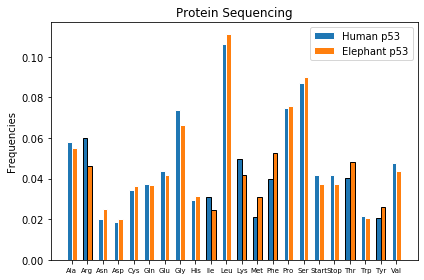

In [14]:
def runFullProgram():
    humanProteins = synthesizeProteins("human_p53.txt")
    elephantProteins = synthesizeProteins("elephant_p53.txt")
    commonalities = commonProteins(humanProteins, elephantProteins)
    differences = findAminoAcidDifferences(humanProteins, elephantProteins)
    displayTextResults(commonalities, differences)
    Labels = makeAminoAcidLabels([humanProteins, elephantProteins])
    freqList = setupChartData(Labels, [humanProteins, elephantProteins])
    freqLabels = ["human", "elephant"]
    edge_List = makeEdgeList(Labels, differences)
    Chart = createChart(Labels, freqList, freqLabels, edge_List)
    return    

runFullProgram()